In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os
import numpy
from scipy import interpolate
import healpy
import gaia_tools.load, gaia_tools.select
from galpy.util import bovy_plot, bovy_coords
import mwdust
import effsel
%pylab inline
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import NullFormatter, FuncFormatter
save_figures= True
numpy.random.seed(1)
nside= 2**5

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# The completeness of *TGAS* for different stellar types

In this notebook, we derive the completeness of *TGAS* for different stellar types as a function of distance and, more generally, as a function of position in the Galaxy. We use the underlying *TGAS* selection function for this and use *TGAS*' color-magnitude distributions for different stellar types to convert the *TGAS* selection function to an effective selection function and effective volume.

For main-sequence stars (dwarfs), we adopt the relations from Pecaut & Mamajek (2013) (downloaded from http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt) to define different stellar types. We first load these relations and the *TGAS* data:

In [3]:
sp= effsel.load_spectral_types()
tgas= gaia_tools.load.tgas()
twomass= gaia_tools.load.twomass()
jk= twomass['j_mag']-twomass['k_mag']
dm= -5.*numpy.log10(tgas['parallax'])+10.
mj= twomass['j_mag']-dm

and then plot the *TGAS* color--absolute-magnitude diagram:

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/patches.py:107: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"



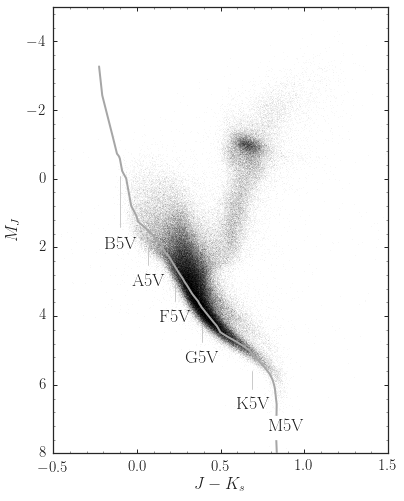

In [4]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,8)
# Select stars with 'good' parallaxes (somewhat circularly depending on their absolute magnitude...)
def good_relplx(mj):
    out= numpy.empty_like(mj)
    out[mj > 5.]= 20.
    out[mj < 0.]= 10.
    out[(mj >= 0)*(mj <= 5.)]= 20.+2.*(mj[(mj >= 0)*(mj <= 5.)]-5.)
    return out
good_plx_indx= (tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))*(jk != 0.)
bovy_plot.bovy_plot((twomass['j_mag']-twomass['k_mag'])[good_plx_indx],
                    (twomass['j_mag']-dm)[good_plx_indx],
                    'k,',rasterized=True,
                    xrange=[-0.5,1.5],yrange=[8.,-5.],alpha=0.03,zorder=1,
                    xlabel=r'$J-K_s$',ylabel=r'$M_J$',clabel=r'$\varpi/\sigma_\varpi$')
sp_indx= numpy.array([(not 'O' in s)*(not 'L' in s)*(not 'T' in s)*(not 'Y' in s)\
                      *(not '.5V' in s) for s in sp['SpT']],dtype='bool')
bovy_plot.bovy_plot((sp['JH']+sp['HK'])[sp_indx],sp['M_J'][sp_indx],
                    color='0.65',lw=2.,zorder=3,overplot=True)
ann_sp= ['B5V','A5V','F5V','G5V','K5V','M5V']
for ap in ann_sp:
    sp_indx= sp['SpT'] == ap
    offset= 1.5
    if ap == 'M5V': offset= -2.
    if ap == 'B5V': offset= 2.5
    t= pyplot.text((sp['JH']+sp['HK'])[sp_indx],sp['M_J'][sp_indx]+offset,
                        r'$\mathrm{%s}$' % ap,size=18.,
                       horizontalalignment='center',verticalalignment='center')
    if ap == 'M5V': t.set_bbox(dict(color='w', alpha=1.,edgecolor='None'))
    else:
        plot(((sp['JH']+sp['HK'])[sp_indx],(sp['JH']+sp['HK'])[sp_indx]),
         (sp['M_J'][sp_indx]+offset-0.5,sp['M_J'][sp_indx]+0.5),'0.75',lw=0.8)

How does $J-K_s$ map to spectral type?

(0.0, 79.0)

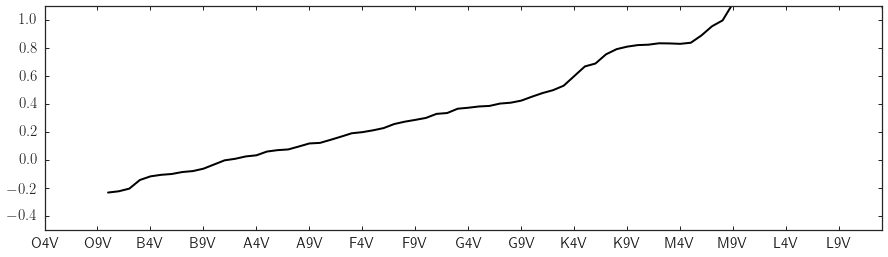

In [5]:
figsize(15,4)
sp_indx= numpy.array([(not '.5V' in s) for s in sp['SpT']],dtype='bool')
plot((sp['JH']+sp['HK'])[sp_indx],'k-',lw=2.)
gca().xaxis.set_ticks(numpy.arange(numpy.sum(sp_indx))[::5])
_= gca().xaxis.set_ticklabels(sp['SpT'][sp_indx][1::5])
ylim(-0.5,1.1)
xlim(0.,79.)

Let's isolate the main-sequence, with a wide cut for star counts and a tight cut for determining the $(J-K_s,M_J)$ relation. The wide cut looks as follows:

In [6]:
figsize(6,5)
sp_indx= numpy.array([(not 'O' in s)*(not 'L' in s)*(not 'T' in s)*(not 'Y' in s)\
                      *(not '.5V' in s)*(s != 'A8V') for s in sp['SpT']],dtype='bool') #A8V has the same MJ as A9V
# Cut out the small part where the color decreases
sp_indx*= (numpy.roll((sp['JH']+sp['HK']),1)-(sp['JH']+sp['HK'])) <= 0.
ip_eems= interpolate.UnivariateSpline((sp['JH']+sp['HK'])[sp_indx],sp['M_J'][sp_indx],k=3,s=1.)
def main_sequence_cut_r(jk,low=False,tight=False):
    """Main-sequence cut, based on MJ, high as in low"""
    j_locus= ip_eems(jk)
    if low and tight:
        dj= 0.2-0.1*(j_locus-5.)
        dj[dj < 0.2]= 0.2
    elif low:
        dj= 0.2-0.25*(j_locus-5.)
        dj[dj < 0.2]= 0.2
    elif tight:
        djk= -(jk-0.6)/20.
        djk[djk>0.]= 0.
        j_locus= ip_eems(jk+djk)
        dj= 0.2-0.5*(j_locus-5.)
        dj[dj < 0.2]= 0.2
        dj[dj > 1.5]= 1.5
        dj*= -1.
    else:
        tjk= jk
        djk= -(jk-0.6)/5.
        djk[djk>0.]= 0.
        j_locus= ip_eems(jk+djk)
        dj= 1.-.8*(j_locus-5.)
        dj[dj < 0.2]= 0.2
        dj[dj > 2.5]= 2.5
        dj*= -1.
    return j_locus+dj

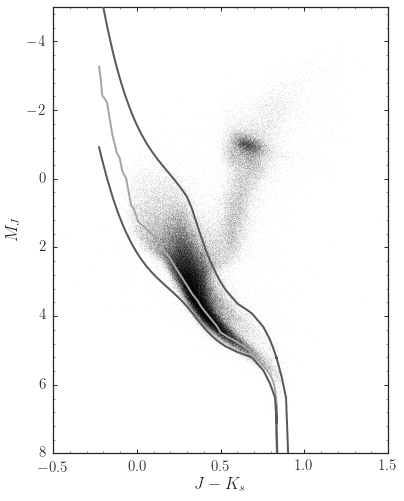

In [7]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,8)
# Select stars with 'good' parallaxes (somewhat circularly depending on their absolute magnitude...)
bovy_plot.bovy_plot((twomass['j_mag']-twomass['k_mag'])[good_plx_indx],
                    (twomass['j_mag']-dm)[good_plx_indx],
                    'k,',rasterized=True,
                    xrange=[-0.5,1.5],yrange=[8.,-5.],alpha=0.03,zorder=1,
                    xlabel=r'$J-K_s$',ylabel=r'$M_J$',clabel=r'$\varpi/\sigma_\varpi$')
sp_indx= numpy.array([(not 'O' in s)*(not 'L' in s)*(not 'T' in s) for s in sp['SpT']],dtype='bool')
bovy_plot.bovy_plot((sp['JH']+sp['HK'])[sp_indx],sp['M_J'][sp_indx],
                    color='0.65',lw=2.,zorder=3,overplot=True)
# Cuts
bovy_plot.bovy_plot((sp['JH']+sp['HK'])[sp_indx],main_sequence_cut_r((sp['JH']+sp['HK'])[sp_indx]),
                    color='0.35',lw=2.,zorder=3,overplot=True)
bovy_plot.bovy_plot((sp['JH']+sp['HK'])[sp_indx],main_sequence_cut_r((sp['JH']+sp['HK'])[sp_indx],low=True),
                    color='0.35',lw=2.,zorder=3,overplot=True)

The tight cut looks like this:

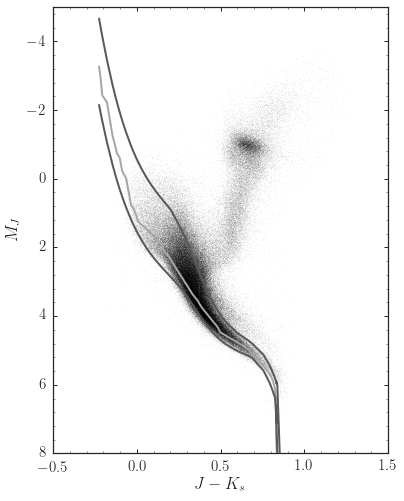

In [8]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,8)
# Select stars with 'good' parallaxes (somewhat circularly depending on their absolute magnitude...)
bovy_plot.bovy_plot((twomass['j_mag']-twomass['k_mag'])[good_plx_indx],
                    (twomass['j_mag']-dm)[good_plx_indx],
                    'k,',rasterized=True,
                    xrange=[-0.5,1.5],yrange=[8.,-5.],alpha=0.03,zorder=1,
                    xlabel=r'$J-K_s$',ylabel=r'$M_J$',clabel=r'$\varpi/\sigma_\varpi$')
sp_indx= numpy.array([(not 'O' in s)*(not 'L' in s)*(not 'T' in s) for s in sp['SpT']],dtype='bool')
bovy_plot.bovy_plot((sp['JH']+sp['HK'])[sp_indx],sp['M_J'][sp_indx],
                    color='0.65',lw=2.,zorder=3,overplot=True)
# Cuts
bovy_plot.bovy_plot((sp['JH']+sp['HK'])[sp_indx],main_sequence_cut_r((sp['JH']+sp['HK'])[sp_indx],tight=True),
                    color='0.35',lw=2.,zorder=3,overplot=True)
bovy_plot.bovy_plot((sp['JH']+sp['HK'])[sp_indx],main_sequence_cut_r((sp['JH']+sp['HK'])[sp_indx],low=True,tight=True),
                    color='0.35',lw=2.,zorder=3,overplot=True)

All of this in one plot:

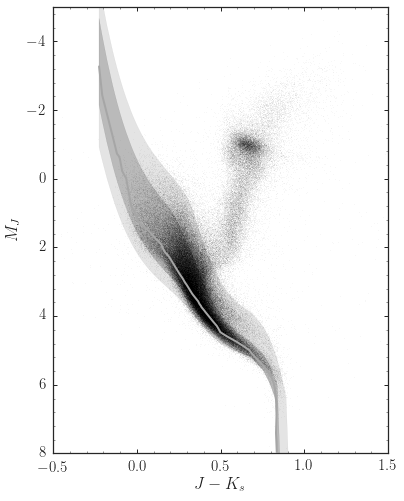

In [9]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,8)
# Select stars with 'good' parallaxes (somewhat circularly depending on their absolute magnitude...)
def good_relplx(mj):
    out= numpy.empty_like(mj)
    out[mj > 5.]= 20.
    out[mj < 0.]= 10.
    out[(mj >= 0)*(mj <= 5.)]= 20.+2.*(mj[(mj >= 0)*(mj <= 5.)]-5.)
    return out
good_plx_indx= (tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))*(jk != 0.)
bovy_plot.bovy_plot((twomass['j_mag']-twomass['k_mag'])[good_plx_indx],
                    (twomass['j_mag']-dm)[good_plx_indx],
                    'k,',rasterized=True,
                    xrange=[-0.5,1.5],yrange=[8.,-5.],alpha=0.03,zorder=3,
                    xlabel=r'$J-K_s$',ylabel=r'$M_J$',clabel=r'$\varpi/\sigma_\varpi$')
sp_indx= numpy.array([(not 'O' in s)*(not 'L' in s)*(not 'T' in s)*(not 'Y' in s)\
                      *(not '.5V' in s) for s in sp['SpT']],dtype='bool')
bovy_plot.bovy_plot((sp['JH']+sp['HK'])[sp_indx],sp['M_J'][sp_indx],
                    color='0.65',lw=2.,zorder=4,overplot=True)
# Cuts
sp_indx= numpy.array([(not 'O' in s)*(not 'L' in s)*(not 'T' in s) for s in sp['SpT']],dtype='bool')
pyplot.fill_between((sp['JH']+sp['HK'])[sp_indx],main_sequence_cut_r((sp['JH']+sp['HK'])[sp_indx]),
                    main_sequence_cut_r((sp['JH']+sp['HK'])[sp_indx],low=True),
                    color='0.65',zorder=1,alpha=0.3)
pyplot.fill_between((sp['JH']+sp['HK'])[sp_indx],main_sequence_cut_r((sp['JH']+sp['HK'])[sp_indx],tight=True),
                    main_sequence_cut_r((sp['JH']+sp['HK'])[sp_indx],tight=True,low=True),
                    color='0.35',zorder=1,alpha=0.3)

## Completeness as a function of distance for different stellar types

Let's now compute the effective selection function as a function of distance for different stellar typess. We first load the effective selection. We'll assume that there is no dust extinction here; otherwise this function depends on the location on the sky.

In [10]:
tsf= gaia_tools.select.tgasSelect()
tesf= gaia_tools.select.tgasEffectiveSelect(tsf,dmap3d=mwdust.Zero())

In [11]:
dms= numpy.linspace(0.,15.,1001)
dists= 10.**(0.2*dms-2.)
ra_cen, dec_cen= -100., 40. #Just some location in the good part of the sky
SpTypes= ['B','A','F','G','K','M']
good_plx_indx= (tgas['parallax']/tgas['parallax_error'] > (good_relplx(mj)))*(jk != 0.)
esfs= numpy.empty((len(SpTypes),len(dms)))
for ii,sptype in enumerate(SpTypes):
    # Find this stellar type
    jkmin= (sp['JH']+sp['HK'])[sp['SpT']=='%s0V' % sptype]
    if sptype == 'M':
        jkmax= (sp['JH']+sp['HK'])[sp['SpT']=='%s5V' % sptype]
    else:
        jkmax= (sp['JH']+sp['HK'])[sp['SpT']=='%s9V' % sptype]
    jmin= main_sequence_cut_r(jkmax)
    jmax= main_sequence_cut_r(jkmin)
    good_sampling= good_plx_indx*(jk > jkmin)*(jk < jkmax)\
                    *(mj < main_sequence_cut_r(jk,tight=True,low=True))\
                    *(mj > main_sequence_cut_r(jk,tight=True))
    esfs[ii]= tesf(dists,ra_cen,dec_cen,MJ=mj[good_sampling],JK=jk[good_sampling])

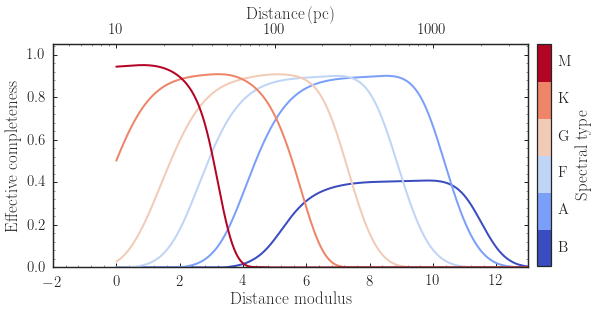

In [12]:
figsize(8,4)
cmap= cm.coolwarm
for ii,sptype in enumerate(SpTypes):
    bovy_plot.bovy_plot(dms,esfs[ii],'-',
                        color=cmap(float(ii)/(len(SpTypes)-1)),
                        lw=2.,overplot=ii>0,
                        xlabel=r'$\mathrm{Distance\ modulus}$',
                        ylabel=r'$\mathrm{Effective\ completeness}$',
                        xrange=[-2.,13.],
                        yrange=[0.,1.05])
# Add distance axis on top
xmin, xmax= pyplot.gca().xaxis.get_view_interval()
ax2= pyplot.twiny()
ax2.set_xscale('log')
ax2.xaxis.set_view_interval(10.**(0.2*xmin+1.),10.**(0.2*xmax+1.),ignore=True)
ax2.set_xlabel('$\mathrm{Distance}\,(\mathrm{pc})$',
               ha='center',x=0.5)
ax2.xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
#ax2.xaxis.set_major_formatter(major_formatter)
# Add colorbar
ticknames= [r'$\mathrm{%s}$' % sptype for sptype in SpTypes]
ticks= numpy.arange(len(SpTypes))
fig= pyplot.gcf()
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.965, 0.13, 0.025, 0.77])
tcmap = matplotlib.colors.ListedColormap([cmap(f) for f in numpy.linspace(0.,1.,len(ticks))])
sm = pyplot.cm.ScalarMappable(cmap=tcmap,
                              norm=pyplot.Normalize(vmin=-0.5,vmax=len(SpTypes)-0.5))
sm._A = []
cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,
                   ticks=ticks)
cbar.set_ticklabels(ticknames)
cbar.set_label(r'$\mathrm{Spectral\ type}$')
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','effsel_ms_distance.pdf'),
                bbox_inches='tight')